# E-tivity 3 : Gerard O'Rourke, Student number : 24514772
This workbook is for the classification task of E-tivity3.  It follows the following structure

It follows the following structure

1. [The workbook environment is setup](#Setup)
1. [The next section has some EDA related to this Etivity](#EDA)
1. [The data preprocessing pipeline is setup](#Data-PreProcess-Pipeline)
2. [The binary value for insurance cost is generated](#Generate-insurance_cost_binary)
1. [The Dimension Reduction Algorithms and parameters are listed](#Dimension-Reduction-Setup)
2. [The data is split into training and test datasets](#Split-the-data-into-training-and-test-datasets)
1. [The SVM Classifier pipeline is defined](#SVM-Classification-Pipeline)
1. [The Random Forest classifier pipeline is defined](#Random-Forest-Classification-Pipeline)
1. [The KNeighbors Classifier pipeline is defined](#KNeighborsClassifier-Pipeline)
1. [The Classifiers are executed and models are evaluated against the test data and a conclusion is drawn on the best classifer](#Compare-Classifier-Models-on-Test-Set)

Note: RandomState was set to 42 for the SVM and Random Forest classifier as the results (as in which classifier was best) was occasionally changing between runs.


## Setup

In [358]:
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import set_config, svm
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, auc, precision_recall_fscore_support, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler  # needed for data preparation

print(sklearn.__version__)

# needed for changing Ordinal values - see education
pd.set_option("future.no_silent_downcasting", True)
#sklearn.set_config(enable_metadata_routing=True)
set_config(transform_output='pandas')


1.6.1


### Load the data and keep a copy

In [359]:
# Load the dataset
df = pd.read_csv("./insurance.csv")

# keep a copy
df_original = df

print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (1338, 7)


## EDA

In [360]:
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [361]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [362]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [363]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [364]:
numerical_attribute = ['age', 'bmi', 'children']

categorical_attribute = ['gender', 'smoker', 'region']

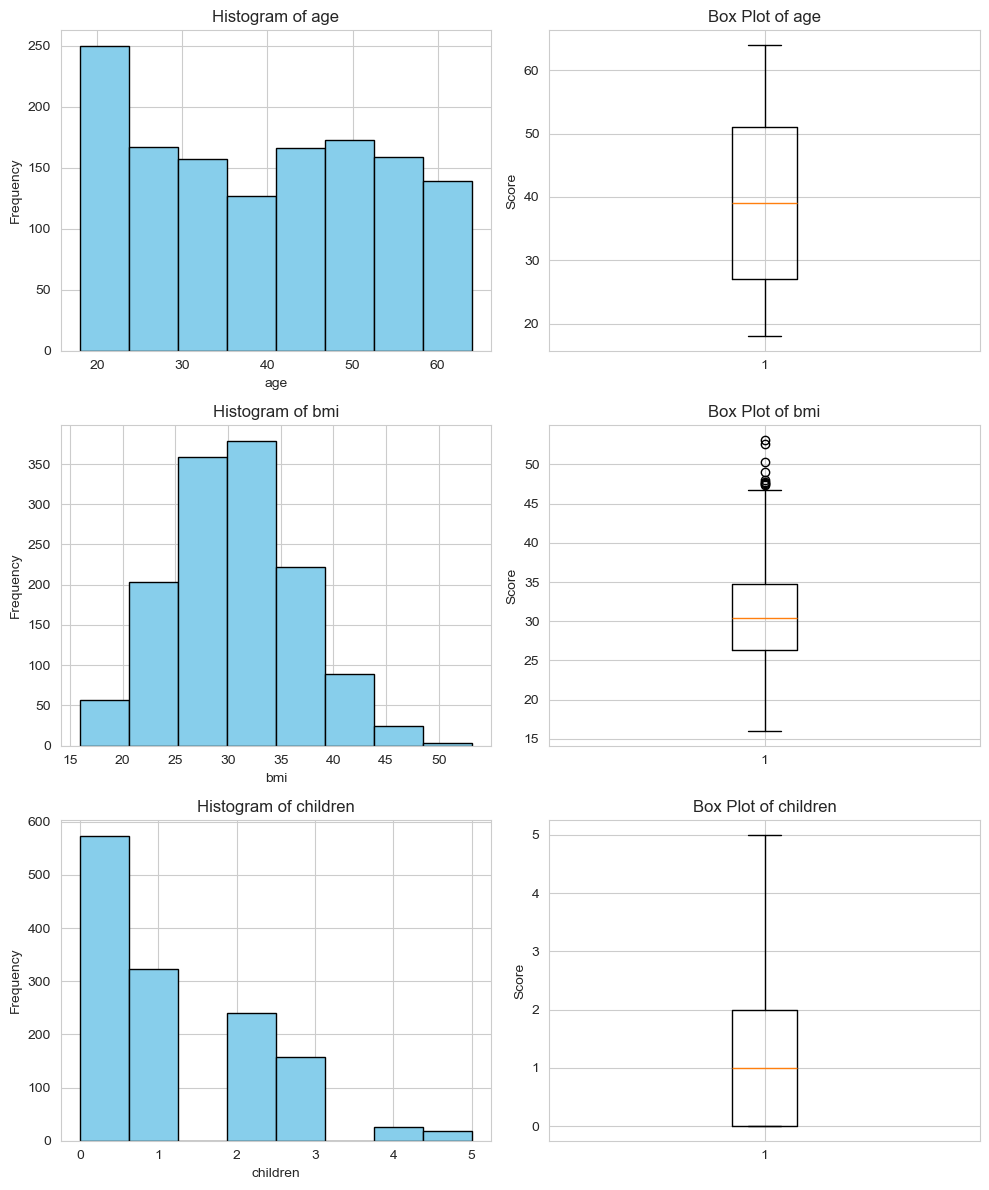

In [365]:
# df.boxplot(column=numerical_attribute)
# Set up the figure with two subplots side by side
fig, axes = plt.subplots(nrows=len(numerical_attribute), ncols=2, figsize=(10, 4 * len(numerical_attribute)))

for row, attribute in enumerate(numerical_attribute):
	# Histogram
	axes[row, 0].hist(df[attribute], bins=8, color='skyblue', edgecolor='black')
	axes[row, 0].set_title(f'Histogram of {attribute}')
	axes[row, 0].set_xlabel(attribute)
	axes[row, 0].set_ylabel('Frequency')

	# Box plot
	axes[row, 1].boxplot(df[attribute], vert=True)
	axes[row, 1].set_title(f'Box Plot of {attribute}')
	axes[row, 1].set_ylabel('Score')

# Display
plt.tight_layout()
plt.show()


#### BMI - has outliers - look at dist. of bmi

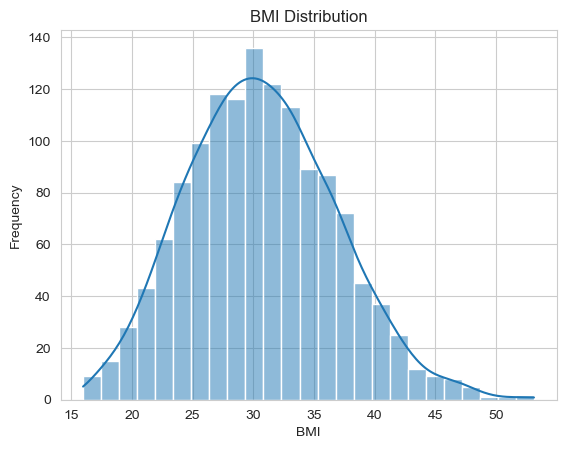

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64

In [366]:

sns.histplot(df['bmi'], kde=True)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

df['bmi'].describe()


In [367]:
df['gender'].value_counts()

gender
male      676
female    662
Name: count, dtype: int64

In [368]:
df['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [369]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

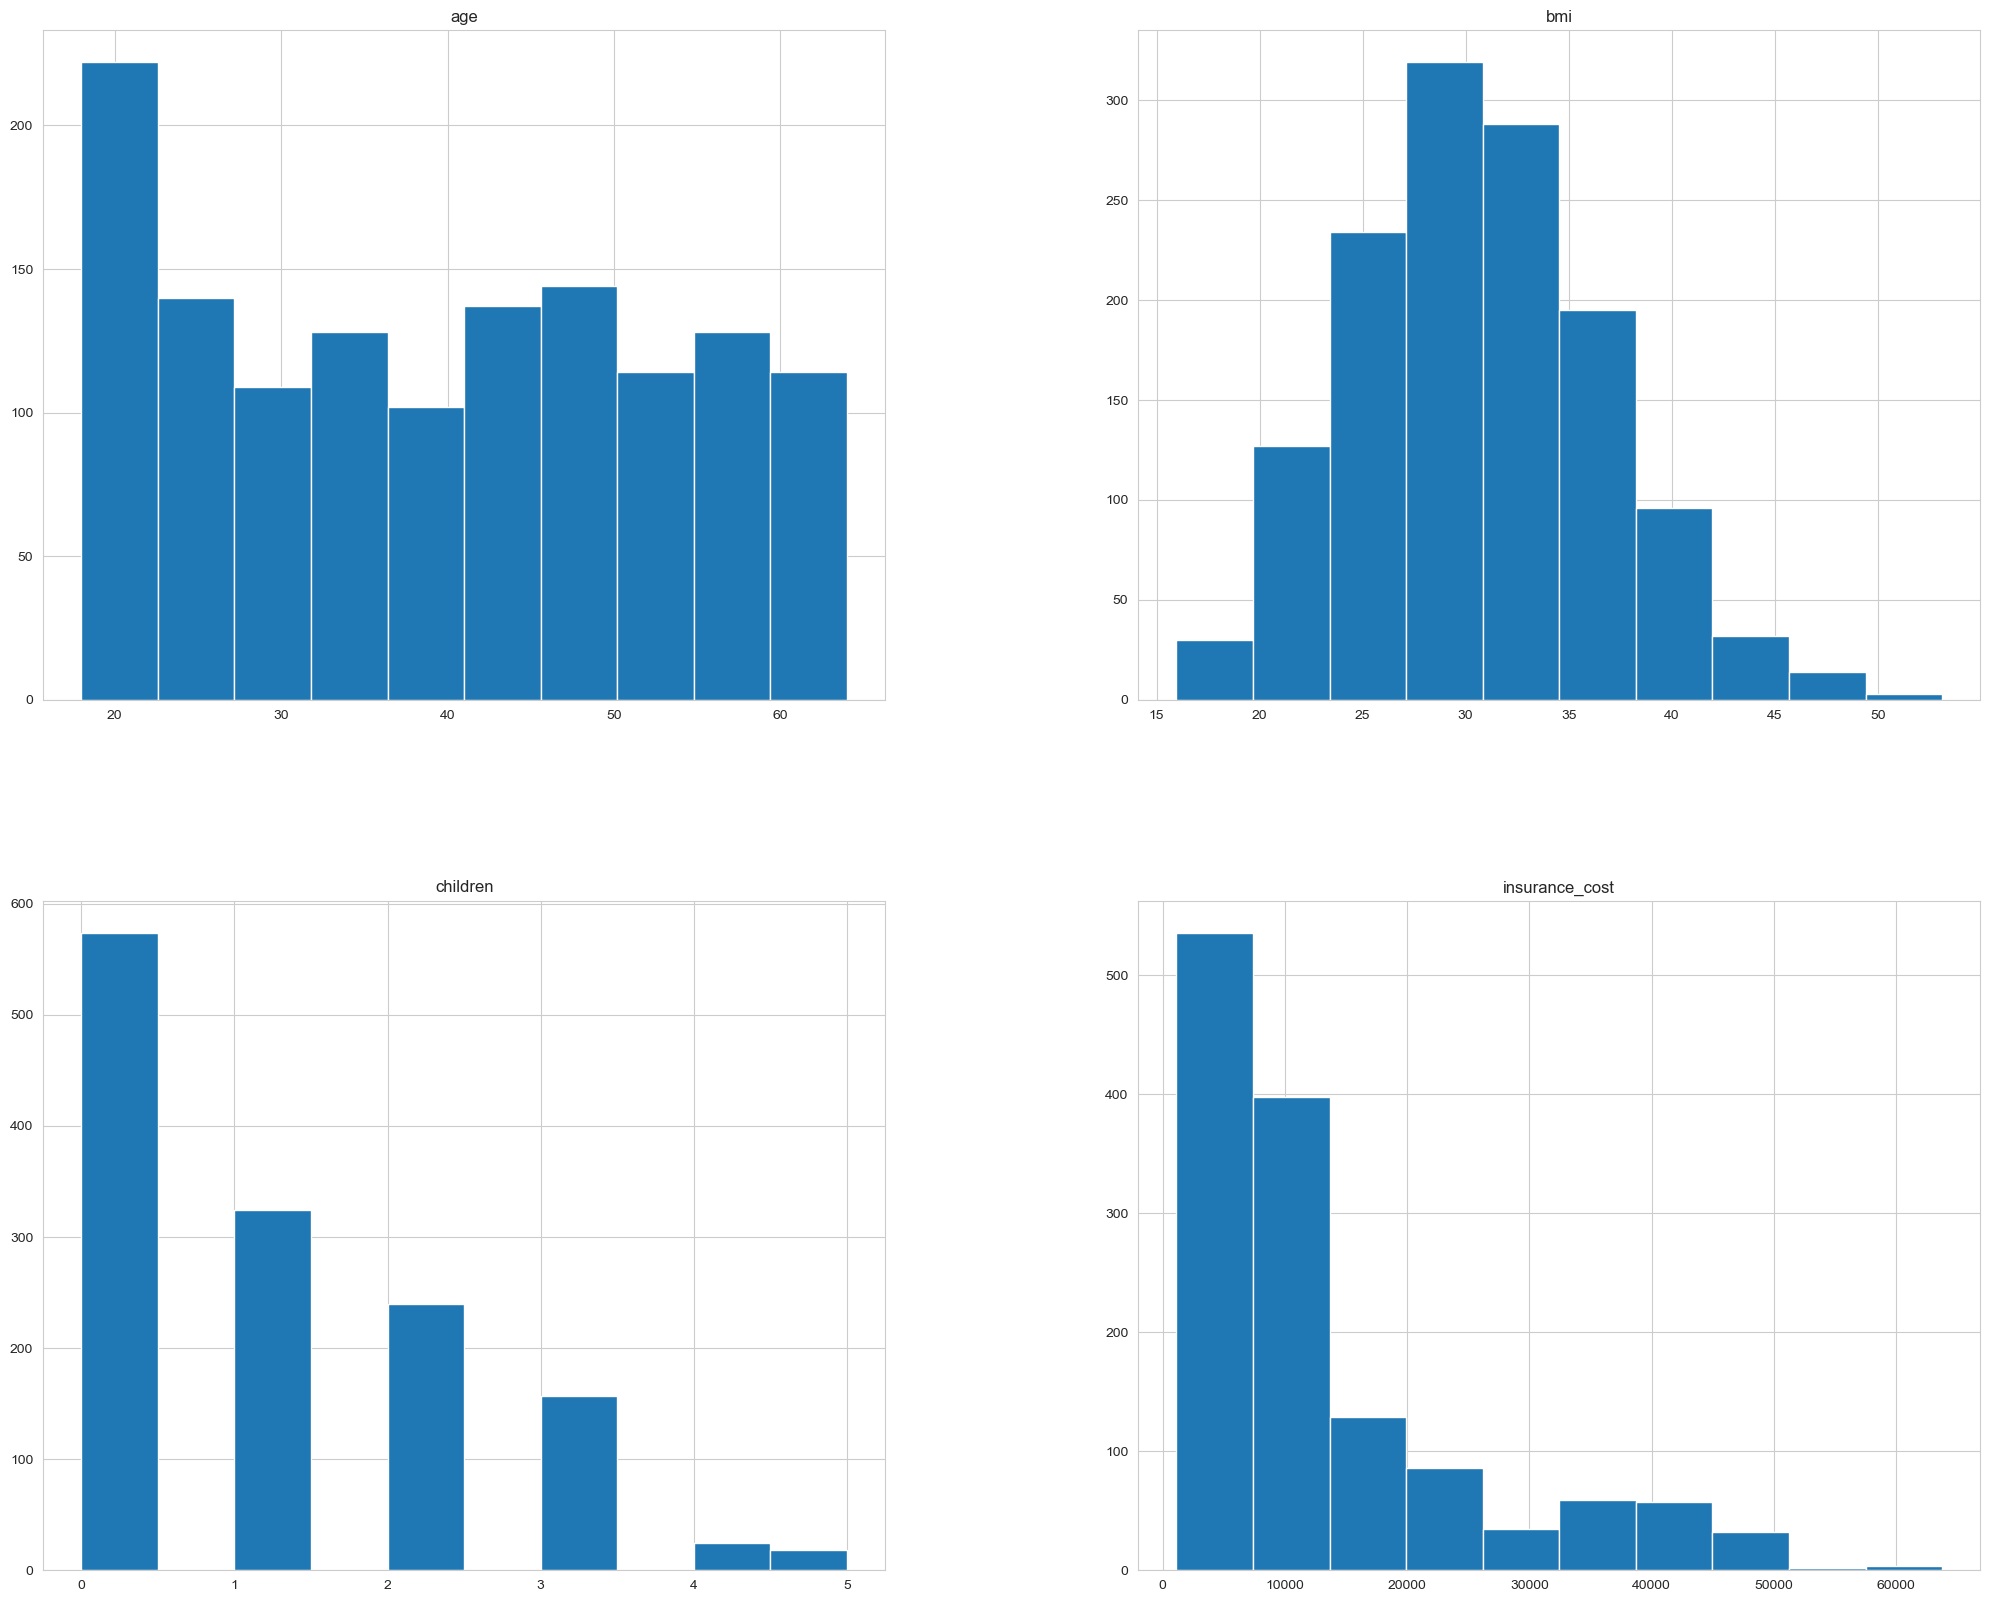

In [370]:
df.select_dtypes(include='number').hist(bins=10, figsize=(25, 20))
plt.show()

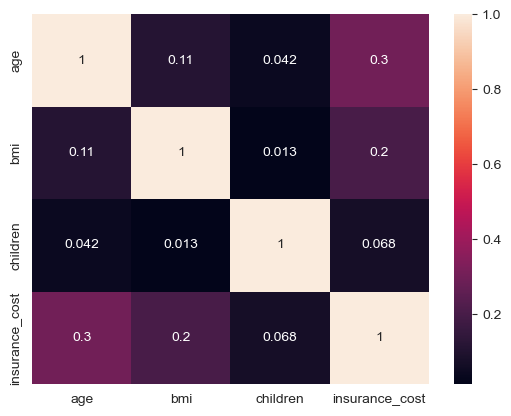

In [371]:
#create correlation matrix of the numeric fields
df_for_heatmap = df.select_dtypes(include=['number'])

sns.heatmap(df_for_heatmap.corr(), annot=True);

### Observations
1. No missing values
1. BMI has outliers
1. Children is right skewed
1. BMI is right skewed - mean > median
1. Gender distribution is more or less even between male and female
1. Approx 20% are smokers
1. People are more or less evenly distributed across the regions, with the southeast having a slightly larger set of people.
2. There's a small correlation between age and bmi and insurance cost

## Data Preprocessing Pipeline
Here we create a pipe to preprocess the data and we'll use this pipe later in the classification pipelines.

| Attribute | Has Zeros | Outliers | Skewed | Map Values | Imput | Scale  | One Hot Encode | Comment |
|-----------|-----------|----------|--------|------------|-------|--------|----------------|---------|
| Age       | No        | No       |        | No         |       | Std    |                |         |
| Bmi       | No        | Yes      | Right  | No         |       | Robust |                |         |
| Children  | Yes       | No       | Right  | No         |       | Std    |                |         |
| Gender    | No        |          |        | Yes        |       |        |                |         |
| Region    | No        |          |        | Yes        |       |        | Yes            |         |
| Smoker    | No        |          |        | Yes        |       |        |                |         |

The pipeline will:
1. Use function mappers to encode gender and smoker attributes
2. do a one hot encoding on the region attribute.
3. Apply a log transform on the children and bmi to address the right skew
4. Scale using RobustScaler for BMI and a standard scalar for Age and Children

#### Define functions for mapping gender + smoker
Here we define the functions to transform gender + smoker

In [372]:
def map_gender(X):
	X = X.copy()
	X['gender'] = X['gender'].map({'male': 0, 'female': 1})
	return X


def map_smoker(X):
	X = X.copy()
	X['smoker'] = X['smoker'].map({'no': 0, 'yes': 1})
	return X


smoker_mapper = FunctionTransformer(map_smoker)
gender_mapper = FunctionTransformer(map_gender)


### Data Preprocess Pipe Definition
Here we define the preprocess_pipeline which will be used later the in classification pipelines

In [373]:
num_pipeline = Pipeline(steps=[
	('attribute_mappers', ColumnTransformer(
		transformers=[
			('age_attr', Pipeline(steps=[
				('log_transform', FunctionTransformer(np.log1p)),
				('scale', RobustScaler()),
			]), ['age']),
			('bmi_attr', Pipeline(steps=[
				('log_transform', FunctionTransformer(np.log1p)),
				('scale', RobustScaler()),
			]), ['bmi']),
			('children_attr', Pipeline(steps=[
				('log_transform', FunctionTransformer(np.log1p)),
				('scale', StandardScaler())]), ['children'])

		]
	))
])

cat_pipeline = Pipeline(steps=[
	('attribute_mappers', ColumnTransformer(
		transformers=[
			('gender_mapper', gender_mapper, ['gender']),
			('smoker_mapper', smoker_mapper, ['smoker']),
			('one-hot', OneHotEncoder(sparse_output=False), ['region'])
		]
	)),

])

#
# Use a col transformer to operate on each set separately
#
col_transform = ColumnTransformer(transformers=[
	('num_pipeline', num_pipeline, numerical_attribute),
	('cat_pipeline', cat_pipeline, categorical_attribute)
], remainder='drop', n_jobs=-1)

# create the actual pipeline
preprocess_pipeline = Pipeline(steps=[
	('preprocess', col_transform),

])


#### Sanity Test the pipeline
Run the pipeline to be sure it's transforming as we expect

In [374]:
# run the pipeline
print(df.columns)
df_post_col_transform = preprocess_pipeline.fit_transform(df)

### sanity check post pipeline
df_post_col_transform.describe()

Index(['age', 'gender', 'bmi', 'children', 'smoker', 'region',
       'insurance_cost'],
      dtype='object')


,num_pipeline__age_attr__age,num_pipeline__bmi_attr__bmi,num_pipeline__children_attr__children,cat_pipeline__gender_mapper__gender,cat_pipeline__smoker_mapper__smoker,cat_pipeline__one-hot__region_northeast,cat_pipeline__one-hot__region_northwest,cat_pipeline__one-hot__region_southeast,cat_pipeline__one-hot__region_southwest
count,1338.000000,1338.000000,1.338000e+03,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,-0.100985,-0.039052,1.062097e-17,0.494768,0.204783,0.242152,0.242900,0.272048,0.242900
std,0.612194,0.729570,1.000374e+00,0.500160,0.403694,0.428546,0.428995,0.445181,0.428995
min,-1.202574,-2.296383,-1.042346e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.576175,-0.522166,-1.042346e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.995936e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.423825,0.477834,9.260819e-01,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,0.784293,2.030303,2.168022e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Generate insurance_cost_binary
We replace the column insurance_cost with
1. a generated value insurance_cost_binary
2. whose value is set to 1 if the insurance_cost > median insurance_cost, otherwise it is set to zero.

In [375]:
median_cost = df['insurance_cost'].median()

print(f"Median Cost {median_cost}")

# compare cost against median, convert True / false to 1 / 0
df['insurance_cost_binary'] = (df['insurance_cost'] > median_cost).astype(int)
df.drop('insurance_cost', axis=1, inplace=True)

y = df['insurance_cost_binary'];
X = df.drop('insurance_cost_binary', axis=1);

print(df)

# check that binary added correctly
binary_counts = df['insurance_cost_binary'].value_counts();
print(binary_counts)

Median Cost 9382.033
      age  gender     bmi  children smoker     region  insurance_cost_binary
0      18    male  33.770         1     no  southeast                      0
1      18    male  34.100         0     no  southeast                      0
2      18  female  26.315         0     no  northeast                      0
3      18  female  38.665         2     no  northeast                      0
4      18  female  35.625         0     no  northeast                      0
...   ...     ...     ...       ...    ...        ...                    ...
1333   64  female  31.825         2     no  northeast                      1
1334   64  female  26.885         0    yes  northwest                      1
1335   64    male  26.410         0     no  northeast                      1
1336   64    male  36.960         2    yes  southeast                      1
1337   64    male  23.760         0    yes  southeast                      1

[1338 rows x 7 columns]
insurance_cost_binary
0    669

## Split the data into training and test datasets
- 80% of the data is used to train the model
- 20% of the data will be used test the model

In [376]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

# Classifier Pipelines
A pipeline is created for each of the classifiers
- SVM
- Random Forest
- KNeighbors Classifier

Each of these pipelines will use the preprocess_data pipeline created above to transform the data for use with these classifiers.  This pipeline is configured to allow the grid search to use each of
- PCA
- RFE
- SelectKBest

as a dimensionalty reduction step with a view to finding the best configuration for the classifier.

In [377]:
# parameters for PCA + RFE
N_FEATURES_OPTIONS = [2, 4, 5, 7]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

# Parameters for SelectKBest
SELECTK_K_VALUES = [5, 7, 9]

## SVM Classification Pipeline
We define the pipeline here that will preprocess the data and run the SVM classifier.  The classifier will be run as part of a grid search to try and determine the best parameters to use in contructing the model.

In [378]:


# create the pipeline
svm_pipe = Pipeline(steps=[
	('preprocess', preprocess_pipeline),
	('reduce_dim', 'passthrough'),
	('svm', svm.SVC(random_state=42, probability=True))
])

In [379]:
set_config(display="diagram")
svm_pipe

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('num_pipeline',
                                                                   Pipeline(steps=[('attribute_mappers',
                                                                                    ColumnTransformer(transformers=[('age_attr',
                                                                                                                     Pipeline(steps=[('log_transform',
                                                                                                                                      FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                                                     ('scale',
                                                                                                                                      RobustScaler())]),
                                                                                                                     ['age']),
                                                                                                                    ('bmi_attr',
                                                                                                                     Pipeline(steps=[('log_transf...
                                                                                    ColumnTransformer(transformers=[('gender_mapper',
                                                                                                                     FunctionTransformer(func=<function map_gender at 0x125918fe0>),
                                                                                                                     ['gender']),
                                                                                                                    ('smoker_mapper',
                                                                                                                     FunctionTransformer(func=<function map_smoker at 0x125918cc0>),
                                                                                                                     ['smoker']),
                                                                                                                    ('one-hot',
                                                                                                                     OneHotEncoder(sparse_output=False),
                                                                                                                     ['region'])]))]),
                                                                   ['gender',
                                                                    'smoker',
                                                                    'region'])]))])),
                ('reduce_dim', 'passthrough'),
                ('svm', SVC(probability=True, random_state=42))])

#### SVM - Define the Grid parameters parameters
Here we specify the parameters for SVM (C, Gamma and Kernel) that the grid search will use to try and find the best configuration of these for the model.  In addition we configure the grid search to apply RFE, PCA and SelectKBest reduction as part of this search to determine the best configuration.  The settings are shown in the dictionary below

In [380]:

SVM_C_VALUES = [0.1, 1, 10, 100]
SVM_GAMMA_VALUES = [1, 0.1, 0.01, 0.001]
SVM_KERNEL_VALUES = ['rbf', 'linear', 'poly']

svm_grid_params = [
	{
		'svm__C': SVM_C_VALUES,
		'svm__gamma': SVM_GAMMA_VALUES,
		'svm__kernel': SVM_KERNEL_VALUES,

		'reduce_dim': [RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
	},
	{
		'svm__C': SVM_C_VALUES,
		'svm__gamma': SVM_GAMMA_VALUES,
		'svm__kernel': SVM_KERNEL_VALUES,

		'reduce_dim': [PCA(iterated_power=7)],
		'reduce_dim__n_components': N_FEATURES_OPTIONS,
	},
	{
		'svm__C': SVM_C_VALUES,
		'svm__gamma': SVM_GAMMA_VALUES,
		'svm__kernel': SVM_KERNEL_VALUES,

		'reduce_dim': [SelectKBest(score_func=f_classif)],
		'reduce_dim__k': SELECTK_K_VALUES
	}
]



#### Run the grid search, display the best parameters it found.

In [381]:
# Set up cross-validation with a fixed random_state
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run the grid search
search = GridSearchCV(svm_pipe, svm_grid_params, n_jobs=-1, cv=cv, refit=True, error_score='raise')

search.fit(X_train, y_train)  #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_score = search.best_score_
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.930:
Best parameters:  {'reduce_dim': SelectKBest(), 'reduce_dim__k': 7, 'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


## Random Forest Classification Pipeline
We define the pipeline here that will preprocess the data and run the Randon Forest classifier.  The classifier will be run as part of a grid search to try and determine the best parameters to use in contructing the model.

In [382]:
random_forest_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
									 ('reduce_dim', 'passthrough'),
									 ('random_forest', RandomForestClassifier(random_state=42))

									 ]
							  )
set_config(display="diagram")
random_forest_pipe

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('num_pipeline',
                                                                   Pipeline(steps=[('attribute_mappers',
                                                                                    ColumnTransformer(transformers=[('age_attr',
                                                                                                                     Pipeline(steps=[('log_transform',
                                                                                                                                      FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                                                     ('scale',
                                                                                                                                      RobustScaler())]),
                                                                                                                     ['age']),
                                                                                                                    ('bmi_attr',
                                                                                                                     Pipeline(steps=[('log_transf...
                                                                                    ColumnTransformer(transformers=[('gender_mapper',
                                                                                                                     FunctionTransformer(func=<function map_gender at 0x125918fe0>),
                                                                                                                     ['gender']),
                                                                                                                    ('smoker_mapper',
                                                                                                                     FunctionTransformer(func=<function map_smoker at 0x125918cc0>),
                                                                                                                     ['smoker']),
                                                                                                                    ('one-hot',
                                                                                                                     OneHotEncoder(sparse_output=False),
                                                                                                                     ['region'])]))]),
                                                                   ['gender',
                                                                    'smoker',
                                                                    'region'])]))])),
                ('reduce_dim', 'passthrough'),
                ('random_forest', RandomForestClassifier(random_state=42))])

#### Random Forest - Define the Grid parameters parameters
The settings are shown in the dictionary below

In [383]:
RANDOM_FOREST_N_ESTIMATORS = [100, 200, 300]
RANDOM_FOREST_MAX_DEPTH = [8, 10, 12, 15]

random_forest_grid_params = [
	{
		'reduce_dim': [PCA(iterated_power=7)],
		'reduce_dim__n_components': N_FEATURES_OPTIONS,

		'random_forest__n_estimators': RANDOM_FOREST_N_ESTIMATORS,
		'random_forest__max_depth': RANDOM_FOREST_MAX_DEPTH
	},
	{
		'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,

		'random_forest__n_estimators': RANDOM_FOREST_N_ESTIMATORS,
		'random_forest__max_depth': RANDOM_FOREST_MAX_DEPTH
	},
	{
		# select the best 5 features, use classification function
		'reduce_dim': [SelectKBest(score_func=f_classif)],
		'reduce_dim__k': SELECTK_K_VALUES,

		'random_forest__n_estimators': RANDOM_FOREST_N_ESTIMATORS,
		'random_forest__max_depth': RANDOM_FOREST_MAX_DEPTH
	}

]

#### Run the grid search

In [384]:
# Set up cross-validation with a fixed random_state
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(random_forest_pipe, random_forest_grid_params, n_jobs=-1, cv=cv, refit=True)
search.fit(X_train, y_train)  #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
random_forest_best_score = search.best_score_
random_forest_best_params = search.best_params_
random_forest_best_model = search.best_estimator_

Best CV score = 0.942:
Best parameters:  {'random_forest__max_depth': 8, 'random_forest__n_estimators': 300, 'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 7}


## KNeighborsClassifier Pipeline

In [385]:
# create the pipeline
knn_pipe = Pipeline(steps=[
	('preprocess', preprocess_pipeline),
	('reduce_dim', 'passthrough'),
	('knn', KNeighborsClassifier())
])

set_config(display="diagram")
knn_pipe

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('num_pipeline',
                                                                   Pipeline(steps=[('attribute_mappers',
                                                                                    ColumnTransformer(transformers=[('age_attr',
                                                                                                                     Pipeline(steps=[('log_transform',
                                                                                                                                      FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                                                     ('scale',
                                                                                                                                      RobustScaler())]),
                                                                                                                     ['age']),
                                                                                                                    ('bmi_attr',
                                                                                                                     Pipeline(steps=[('log_transf...
                                                                                    ColumnTransformer(transformers=[('gender_mapper',
                                                                                                                     FunctionTransformer(func=<function map_gender at 0x125918fe0>),
                                                                                                                     ['gender']),
                                                                                                                    ('smoker_mapper',
                                                                                                                     FunctionTransformer(func=<function map_smoker at 0x125918cc0>),
                                                                                                                     ['smoker']),
                                                                                                                    ('one-hot',
                                                                                                                     OneHotEncoder(sparse_output=False),
                                                                                                                     ['region'])]))]),
                                                                   ['gender',
                                                                    'smoker',
                                                                    'region'])]))])),
                ('reduce_dim', 'passthrough'),
                ('knn', KNeighborsClassifier())])

#### Setup the KNN grid parameters

In [386]:
knn_grid_params = [
	{
		'reduce_dim': [PCA(iterated_power=7)],
		'reduce_dim__n_components': N_FEATURES_OPTIONS,
		'knn__n_neighbors': list(range(1, 21)),

		'knn__weights': ['uniform', 'distance'],
		'knn__metric': ['minkowski', 'euclidean', 'manhattan']
	},
	{
		'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,

		'knn__n_neighbors': list(range(1, 21)),
		'knn__weights': ['uniform', 'distance'],
		'knn__metric': ['minkowski', 'euclidean', 'manhattan']
	},
	{
		'reduce_dim': [SelectKBest(score_func=f_classif)],
		'reduce_dim__k': SELECTK_K_VALUES,

		'knn__n_neighbors': list(range(1, 21)),
		'knn__weights': ['uniform', 'distance'],
		'knn__metric': ['minkowski', 'euclidean', 'manhattan']

	},
]

####  Run the grid search

In [387]:
# Set up cross-validation with a fixed random_state
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(knn_pipe, knn_grid_params, n_jobs=-1, cv=cv, refit=True)
search.fit(X_train, y_train)  #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
knn_best_score = search.best_score_
knn_best_params = search.best_params_
knn_best_model = search.best_estimator_


Best CV score = 0.932:
Best parameters:  {'knn__metric': 'minkowski', 'knn__n_neighbors': 5, 'knn__weights': 'uniform', 'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 4}


## Compare Classifier Models on Test Set

### Compare the CV Scores

In [388]:
import pandas as pd

print("SVM")
print("\tBest CV score = %0.3f:" % SVM_best_score)
print("\tBest parameters: ", SVM_best_params)
#print("Best model: ", SVM_best_model)

print("Random Forest")
print("\tBest CV score = %0.3f:" % random_forest_best_score)
print("\tBest parameters: ", random_forest_best_params)
#print("Best model: ", random_forest_best_model)

print("KNeighbors")
print("\tBest CV score = %0.3f:" % knn_best_score)
print("\tBest parameters: ", knn_best_params)
#print("Best model: ", knn_best_model)


SVM
	Best CV score = 0.930:
	Best parameters:  {'reduce_dim': SelectKBest(), 'reduce_dim__k': 7, 'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Random Forest
	Best CV score = 0.942:
	Best parameters:  {'random_forest__max_depth': 8, 'random_forest__n_estimators': 300, 'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 7}
KNeighbors
	Best CV score = 0.932:
	Best parameters:  {'knn__metric': 'minkowski', 'knn__n_neighbors': 5, 'knn__weights': 'uniform', 'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 4}


Random forest has the best CV score.

#### Helper function to evaluate the model against the test data set and extract the results

In [389]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
	# compute probabilistic predictiond for the evaluation set
	_probabilities = model.predict_proba(X_test)[:, 1]

	# compute exact predictiond for the evaluation set
	_predicted_values = model.predict(X_test)

	# compute accuracy
	_accuracy = accuracy_score(y_test, _predicted_values)

	# compute precision, recall and f1 score for class 1
	_precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])

	# compute fpr and tpr values for various thresholds
	# by comparing the true target values to the predicted probabilities for class 1
	_fpr, _tpr, _ = roc_curve(y_test, _probabilities)

	# compute true positive rates for the values in the array mean_fpr
	_tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])

	# compute the area under the curve
	_auc = auc(_fpr, _tpr)

	return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

### Extract and Graph the results for
- Accuracy
- Precision
- Recall
- F1-Score


In [390]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [391]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test,
																				   random_forest_best_model)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, knn_best_model)

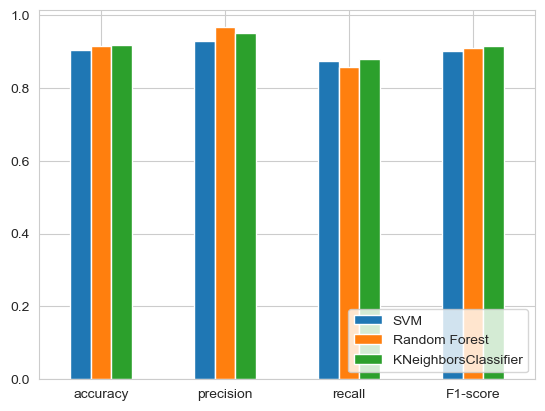

In [392]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])

index = ['accuracy', 'precision', 'recall', 'F1-score']

df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'KNeighborsClassifier': KNN_metrics},
						  index=index)

df_metrics.plot.bar(rot=0)

plt.legend(loc="lower right")

plt.show()

#### Display
- Accuracy
- Precision
- Recall
- F1-Score

metrics in number form for SVM, Random Forest and KNeighbors Classifiers

In [393]:
print(index)
print("SVM ", SVM_metrics)
print("RF  ", RF_metrics)
print("KNeighborsClassifier ", KNN_metrics)

['accuracy', 'precision', 'recall', 'F1-score']
SVM  [0.90298507 0.92857143 0.87313433 0.9       ]
RF   [0.9141791  0.96638655 0.85820896 0.90909091]
KNeighborsClassifier  [0.91791045 0.9516129  0.88059701 0.91472868]


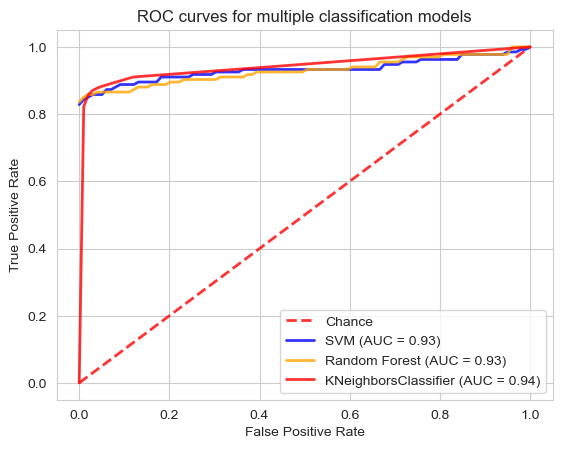

In [394]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0, :], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0, :], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0, :], lw=2, color='red', label='KNeighborsClassifier (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

### Conclusion
1. Each classifier performed well.
2. As noted earlier, before random_state was set, RandomForest would usually report the best figures but not always.  However once the random state was added, the figures for RandomForest and SVM were not as good.  KNeighbours had better values in terms of accuracy, recall and F1 score.  The AUC score for KNeighbours is also better than that of SVM and Random Forest.  So I'd select KNeighbours as the classifier to use.  It's CV score was not as good as RandomForest, but it was marginally better than SVM.
1. The best parameters chosen by the grid search with KNeighbours are:  {'knn__metric': 'minkowski', 'knn__n_neighbors': 5, 'knn__weights': 'uniform', 'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 4}
1. The ROC curves show that each model is significantly better than a random guess.

#### Data Dictionary / Columns (https://www.kaggle.com/datasets/mirichoi0218/insurance)

1. age: age of primary beneficiary
1. sex: insurance contractor gender, female, male
1. bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
1. children: Number of children covered by health insurance / Number of dependents
1. smoker: Smoking
1. region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
1. charges: Individual medical costs billed by health insurance

Definitions
1. F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

1. The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1 and the worst value is 0.
2. The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
3. The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.  The best value is 1 and the worst value is 0.